Analysis of the Icarust data for the application note. Data is (as of 11/05/2023) found on old prom in `/data/projects/rory_says_hi/icarust_paper_data`, with reads at `/data/icarust_paper_data`, although these will likely be moved to `/mnt/waterprom/rory_backup/icarust_paper_data`.

### Workflow
1. Basecalled the reads generated by Icarust with Guppy 6.4.6 HAC
    ```bash
    guppy_basecaller_supervisor --num_clients 8 -i <ICARUST_OUT_DIR>/fast5_pass/ -q 4000 -c dna_r9.4.1_450bps_hac_prom.cfg -p ipc:///tmp/.guppy/5555 -s fastq_out/ --compress_fastq --disable_pings
    ```
1. Mapped the reads using minimap2 
    ```bash
    cat /data/icarust_paper_data/control_icarust_playback/20230510_1332_MS00000_FAWFAKE2_5d6021e8/fastq_*/*.fastq.gz | minimap2-2.26_x64-linux/minimap2 -x map-ont --secondary=no -o control_icarust_playback.paf /data/projects/rory_says_hi/refs/hg_38_no_alts_22.mmi -
    ```
1. read in the PAF file
1. split by contigs
1. plot read count per contig


In [1]:
from itertools import zip_longest
from pathlib import Path

print(Path().cwd())
from string import ascii_uppercase

import matplotlib.font_manager as font_manager
import matplotlib.image as img
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import EngFormatter

/data/projects/rory_says_hi/icarust_paper_data/notebooks


In [2]:
plt.style.use("dotfiles-rm/thesis/thesis.mplstyle")
font_dir = "dotfiles-rm/"
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
sns.set_palette("colorblind")
rcParams["font.family"] = "Roboto"

In [30]:
PAF_FILES = [
    (
        "playback_paf_files/adaptive_icarust_playback.paf",
        "Playback",
        "Adaptive",
    ),
    (
        "playback_paf_files/control_icarust_playback.paf",
        "Playback",
        "Control",
    ),
    ("R9_paf_files/control_icarust_R9.paf", "Icarust R9", "Control"),
    (
        "R9_paf_files/adaptive_icarust_R9.paf",
        "Icarust R9",
        "Adaptive",
    ),
    (
        "R10_paf_files/control_icarust_R10.paf",
        "Icarust R10",
        "Control",
    ),
    (
        "R10_paf_files/adaptive_icarust_R10.paf",
        "Icarust R10",
        "Adaptive",
    ),
]
with open("hg38_contig_to_human_readable.txt") as fh:
    CONTIG_LOOKUP = dict([line.split()[::-1] for line in fh])

In [31]:
def median_read_length(group: pd.DataFrame) -> int:
    """
    Returns the median read length for a given group
    """
    return group["read_length"].median()

In [32]:
def total_yield(group: pd.DataFrame) -> float:
    """
    Returns the total yield for a given group
    """
    return group["read_length"].sum()

In [33]:
def yield_ratio(group: pd.DataFrame) -> float:
    """
   c Yield ratio for the adaptive divided by the control
    """
    adaptive_yield = group[group["Condition"] == "Adaptive"]["read_length"].sum()
    control_yield = group[group["Condition"] == "Control"]["read_length"].sum()
    return adaptive_yield / control_yield

In [34]:
dfs = []
for paf, generation_method, condition in PAF_FILES:
    df_paf = pd.read_csv(
        paf,
        sep="\t",
        header=None,
        names=[
            "read_id",
            "read_length",
            "strand",
            "contig",
            "contig_length",
            "map_start",
            "map_end",
            "map_q",
        ],
        usecols=[0, 1, 4, 5, 6, 7, 8, 11],
    )
    df_paf["Generation method"] = generation_method
    df_paf["Condition"] = condition
    dfs.append(df_paf)
df = pd.concat(dfs)
df = df.sort_values(["contig", "Condition"])
df["Chromosome"] = df["contig"].map(CONTIG_LOOKUP)

value_dfs = []
values_types = ["Median read length", "Yield", "Yield ratio"]
aggregator = dict(zip(values_types, (median_read_length, total_yield, yield_ratio)))
groups = (
    ["Generation method", "Condition", "Chromosome"],
    ["Generation method", "Condition", "Chromosome"],
    ["Generation method", "Chromosome"],
)
group_bys = dict(zip_longest(values_types, groups))
for value in values_types:
    value_df = df.copy()
    group = group_bys[value]
    value_df = value_df.set_index(group)
    # calculate the median, yield ratio and yield
    value_df["value"] = value_df.groupby(group).apply(aggregator[value])
    value_df = value_df.reset_index()
    value_df["value_type"] = value
    value_dfs.append(value_df)

value_df = pd.concat(value_dfs)
# remove the control column for the yield ratio, as it is always one.
value_df = value_df[
    ~((value_df["value_type"] == "Yield ratio") & (value_df["Condition"] == "Control"))
]

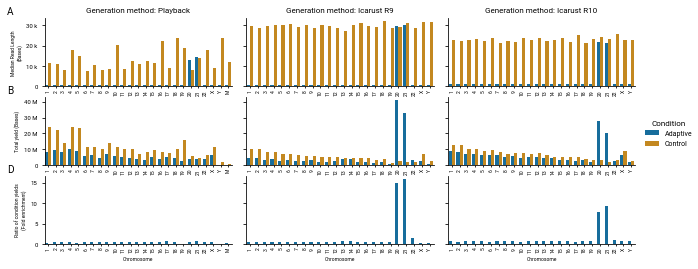

In [41]:
g = (
    sns.catplot(
        data=value_df,
        errorbar=None,
        col="Generation method",
        row="value_type",
        hue="Condition",
        x="Chromosome",
        kind="bar",
        y="value",
        height=1.3,
        aspect=2.3,
        sharey="row",
        sharex=False,
    )
    .tick_params(rotation=90, axis="x", pad=1.1, length=1.8)
    .set_titles(template="{col_var}: {col_name}")
)
axes = g.axes.flatten()
# Sigh, there has to be a way to do this in seaborn
y_labels = (
    "Median Read Length\n(Bases)",
    "Total yield (Bases)",
    "Ratio of condition yields\n(Fold enrichment)",
)
for ind, ax in enumerate(axes):
    if ind < 4:
        ax.xaxis.label.set_visible(False)
    else:
        ax.set_xlabel(ax.xaxis.get_label_text(), fontsize=5)
    # change yaxis font size
    ax.set_ylabel(ax.yaxis.get_label_text(), fontsize=5)
    # Add figure row labels
    if ind in {0, 3, 6}:
        ax.text(-0.2, 1.05, ascii_uppercase[ind // 2], transform=ax.transAxes)
    # Remove the axes titles for second and third rows
    if ind > 2:
        ax.title.set_visible(False)
    ax.yaxis.set_major_formatter(EngFormatter())
    ax.set_ylabel(y_labels[ind // 3])
plt.subplots_adjust(hspace=0.15)

In [36]:
g.savefig("draft_figure_1.png", bbox_inches="tight", dpi=350)

In [37]:
icarust_shot = img.imread("screenshots/icarust_full.png")
real_shot = img.imread("screenshots/real_full.png")
graphs = img.imread("draft_figure_1.png")

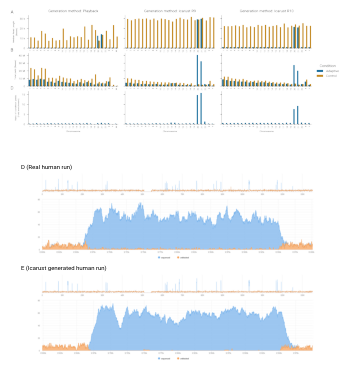

In [38]:
fig = plt.figure(figsize=(6, 7))
gs = GridSpec(3, 1, height_ratios=(2, 1.0, 1), figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])
ax3 = fig.add_subplot(gs[2, :])
ax1.imshow(graphs, aspect="equal")
ax1.set_axis_off()
ax2.imshow(real_shot, aspect="equal")
ax2.set_axis_off()
ax2.text(
    -0.04,
    1.05,
    "D (Real human run)",
    transform=ax2.transAxes,
    fontsize=6,
    fontweight="normal",
)
ax3.imshow(icarust_shot, aspect="equal")
ax3.text(
    -0.04,
    1.05,
    "E (Icarust generated human run)",
    transform=ax3.transAxes,
    fontsize=6,
    fontweight="normal",
)
ax3.set_axis_off()
plt.subplots_adjust(hspace=0.1)

In [39]:
fig.savefig("figure_1.jpg", bbox_inches="tight", dpi=350)